In [ ]:
!pip install rasterio spectral
import rasterio ##  Reads geospatial raster data.
import numpy as np   #Handles numerical operations like arrays and mathematical computations.
import matplotlib.pyplot as plt #Visualizes images and data.

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 19.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.9/212.9 kB 15.7 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import rasterio
from skimage import exposure, filters # Contains utilities for image processing (e.g., normalization, conversions)

If we keep the band data as
integers, we may get unrealisticvalues,(like 106.040) because of rounding issues
or integer limits. Converting bands to a floating-point format (like float32)
is essential to allow precise division. Using astype('f4') ensures each pixel value is stored as a float, so the result stays within the expected range.


In satellite imagery, pixel values may cluster in a narrow range, leading to low contrast. Linear stretching redistributes these values across the available range, improving visibility

Satellite images often contain extreme values (e.g., shadows, highly reflective areas) that can distort the display or processing. The 2% and 98% cutoffs ensure these outliers are ignored.

 Linear stretching is used to enhance image contrast by redistributing pixel intensities.

In [ ]:
rgb = None  #Initializes the variable rgb to None. 'rgb' store the final RGB image after loading the bands.
with rasterio.open('/content/drive/MyDrive/sip_mum_sub/mumbai_subset_sip') as dataset:  #using the rasterio library we open the dataset located at the specified path.
    band_indices = [5, 4, 3]  # Assuming Landsat 8 band order for RGB
    rgb_bands = [dataset.read(band_index) for band_index in band_indices]   # dataset.read(band_index) reads the data for the given band index as a 2D NumPy array (representing pixel values).
      #rgb_bands list contains three arrays, one for each of the Red, Green, and Blue bands. So variable rgb_bands will hold the pixel intensity values for the Red, Green, and Blue channels of the subset image.
    # Normalize based on data type
    if dataset.dtypes[0] == 'uint16':  # 16-bit data
        rgb = np.dstack(rgb_bands).astype(np.float32) / 65535  # scale the value ranging form 0 to 65535 to [0,1]. so that pixel value are normalized and consistent
    elif dataset.dtypes[0] == 'uint8':  # 8-bit data
        rgb = np.dstack(rgb_bands).astype(np.float32) / 255
        rgb = rgb.astype(np.float32) / 65535  # Adjusting to 16 bit values

def linear2_percent_stretch(image):    #linear stretching maps the intensity values between two chosen percentiles
    # Calculate the 2nd and 98th percentiles for each band
    p2, p98 = np.percentile(image, (2, 98), axis=(0, 1))  #axis=(0, 1): Percentiles are calculated across the spatial dimensions of the image (height and width), separately for each channel (e.g., Red, Green, Blue).
    #Finding the 2nd percentile (p2) and 98th percentile (p98) of pixel values for each channel in the image.
    # Rescale each band to the range [0, 1] based on the percentiles
    # The in_range argument should be a tuple of (min, max) values,
    # not a tuple of arrays.
    # We create a tuple of (min, max) from the p2 and p98 arrays.
    #p2 - The pixel value below which 2% of the pixel intensities fall. & p8- The pixel value below which 98% of the pixel intensities fall.
    stretched_image = exposure.rescale_intensity(image, in_range=(p2.min(), p98.max()), out_range=(0, 1))

    return stretched_image

# Enhances contrast by spreading the pixel values more evenly across the full intensity range.
rgb = linear2_percent_stretch(rgb)

In [ ]:
rgb

array([[[0.5866301 , 0.32835963, 0.34269813],
        [0.59669375, 0.17170529, 0.21454252],
        [0.4815407 , 0.16279937, 0.21080211],
        ...,
        [0.06812996, 0.07561087, 0.14703605],
        [0.07293911, 0.07187042, 0.14543292],
        [0.31330875, 0.10811735, 0.17491145]],

       [[0.6568084 , 0.31651482, 0.32604414],
        [0.5560829 , 0.22950442, 0.24758334],
        [0.45206228, 0.1538045 , 0.1958402 ],
        ...,
        [0.0686643 , 0.07935133, 0.14890625],
        [0.09653971, 0.08211215, 0.15344827],
        [0.37849975, 0.10045823, 0.1700132 ]],

       [[0.70418763, 0.32096776, 0.34349966],
        [0.6943022 , 0.18159084, 0.23351209],
        [0.61076504, 0.12788835, 0.18212518],
        ...,
        [0.07133608, 0.09092901, 0.15994954],
        [0.13332094, 0.09778652, 0.16609459],
        [0.3253317 , 0.10295193, 0.17081472]],

       ...,

       [[0.7593151 , 0.43692225, 0.40227842],
        [0.61735535, 0.340917  , 0.33334693],
        [0.6697219 , 0

<ipython-input-5-341b27e62cad>:11: RuntimeWarning: invalid value encountered in arccos
  H = np.arccos(num / (den + 1e-8))  # Avoid division by zero
/usr/local/lib/python3.10/dist-packages/skimage/util/dtype.py:338: RuntimeWarning: invalid value encountered in cast
  return image_out.astype(dtype_out)


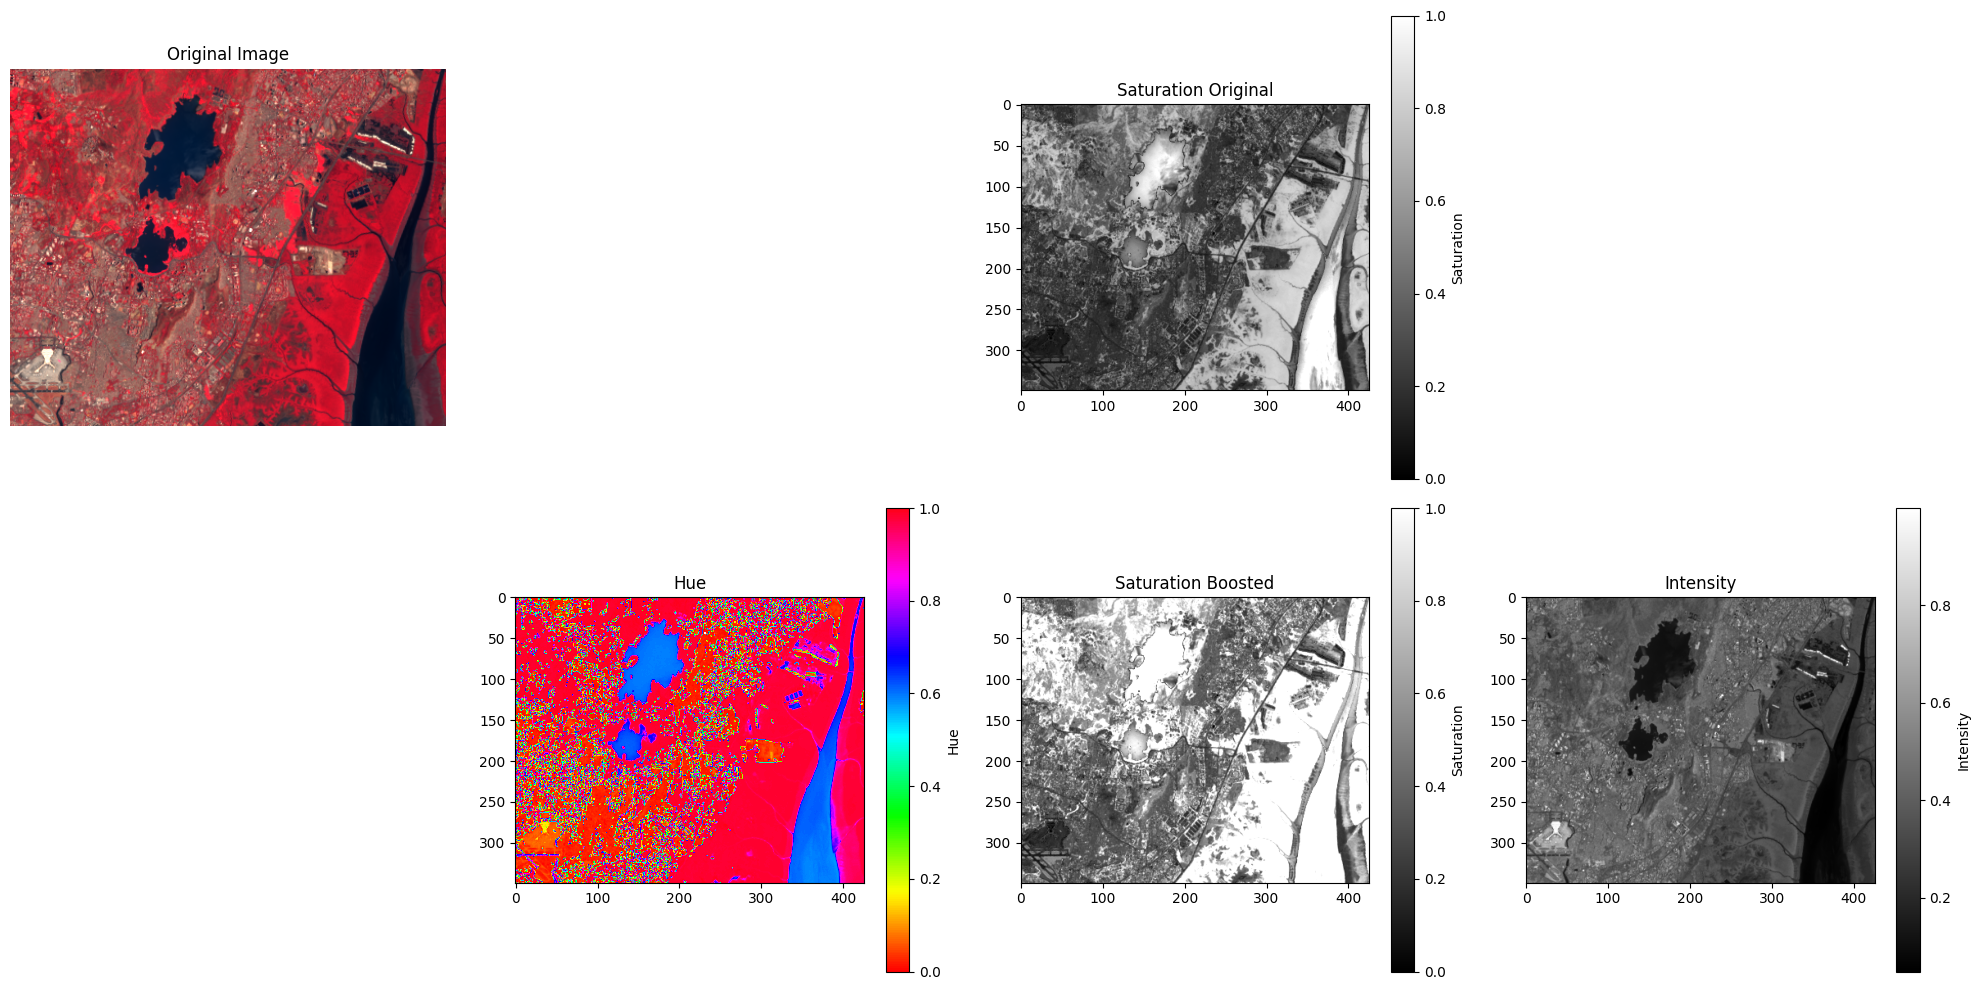

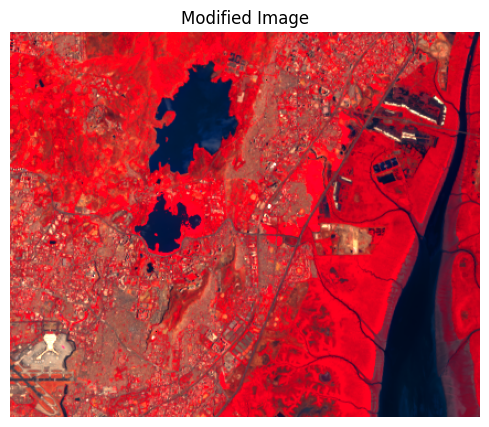

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import io, img_as_float, img_as_ubyte

def rgb_to_hsi(image):  # image is a 3D numpy array representing an RgB image
    R, G, B = image[:,:,0], image[:,:,1], image[:,:,2]
    I = (R + G + B) / 3
    S = 1 - np.min(image, axis=2) / (I + 1e-8)  # Avoid division by zero
    num = 0.5 * ((R - G) + (R - B))
    den = np.sqrt((R - G)**2 + (R - B) * (G - B))
    H = np.arccos(num / (den + 1e-8))  # Avoid division by zero
    H[B > G] = 2 * np.pi - H[B > G]
    H = H / (2 * np.pi)  # Normalize to [0, 1]
    return H, S, I

def hsi_to_rgb(H, S, I):
    R, G, B = np.zeros_like(H), np.zeros_like(H), np.zeros_like(H) #making an array and assigning it as zero.
    H = H * 360  # Convert to degrees
    for i in range(H.shape[0]):
        for j in range(H.shape[1]):
            h = H[i, j]
            if h < 120:
                B[i, j] = I[i, j] * (1 - S[i, j])
                R[i, j] = I[i, j] * (1 + S[i, j] * np.cos(np.radians(h)) / np.cos(np.radians(60 - h)))
                G[i, j] = 3 * I[i, j] - (R[i, j] + B[i, j])
            elif h < 240:
                h -= 120
                R[i, j] = I[i, j] * (1 - S[i, j])
                G[i, j] = I[i, j] * (1 + S[i, j] * np.cos(np.radians(h)) / np.cos(np.radians(60 - h)))
                B[i, j] = 3 * I[i, j] - (R[i, j] + G[i, j])
            else:
                h -= 240
                G[i, j] = I[i, j] * (1 - S[i, j])
                B[i, j] = I[i, j] * (1 + S[i, j] * np.cos(np.radians(h)) / np.cos(np.radians(60 - h)))
                R[i, j] = 3 * I[i, j] - (G[i, j] + B[i, j])
    return np.stack([R, G, B], axis=2)

# Load and normalize image
image = rgb

#img_as_float(io.imread('/content/lake powai 1.png'))

# Convert RGB to HSI
H, S, I = rgb_to_hsi(image)


# Plot HSI Components
plt.figure(figsize=(20, 10))

plt.subplot(2, 4, 1)
plt.title("Original Image")
plt.imshow(image)
plt.axis('off')

plt.subplot(2, 4, 3)
plt.title("Saturation Original")
plt.imshow(S, cmap='gray')  # Saturation in grayscale
plt.colorbar(label='Saturation')

plt.subplot(2, 4, 6)
plt.title("Hue")
plt.imshow(H, cmap='hsv')  # Hue is best visualized with HSV colormap
plt.colorbar(label='Hue')

# Modify Hue and Saturation
S = np.clip(S * 1.7, 0, 1)  # Boost Saturation
plt.subplot(2, 4, 7)
plt.title("Saturation Boosted")
plt.imshow(S, cmap='gray')  # Saturation in grayscale
plt.colorbar(label='Saturation')

plt.subplot(2, 4, 8)
plt.title("Intensity")
plt.imshow(I, cmap='gray')  # Intensity in grayscale
plt.colorbar(label='Intensity')



# Convert back to RGB
modified_image = hsi_to_rgb(H, S, I)
modified_image = np.clip(modified_image, 0, 1)  # Clamp values to [0, 1]
modified_image = img_as_ubyte(modified_image)  # Convert to 8-bit unsigned integers

plt.tight_layout()
plt.show()

# Display Original and Modified RGB Images
plt.figure(figsize=(10, 5))

plt.title("Modified Image")
plt.imshow(modified_image)
plt.axis('off')

plt.show()
